In [13]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os
import pinocchio as pin

from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.decomposition.asf import ASF

from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.description.builder import jps_graph2pinocchio_robot, jps_graph2pinocchio_robot_3d_constraints
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.default_traj import add_auxilary_points_to_trajectory, convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import ManipulabilityReward, ZRRReward
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT, URDFLinkCreater3DConstraints
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L, get_preset_by_index
from auto_robot_design.generator.topologies.bounds_preset import get_preset_by_index_with_bounds
from auto_robot_design.optimization.saver import ProblemSaver
from auto_robot_design.utils.configs import inertial_config_two_link_workspace, get_mesh_builder, inertial_config_two_link_six_trajectories, jacobian_config_two_link_workspace
from auto_robot_design.generator.user_generator.graph_generator import TopologyManager2D
from auto_robot_design.description.kinematics import JointPoint

In [14]:
builder, crag, soft_constrain, reward_manager = jacobian_config_two_link_workspace()

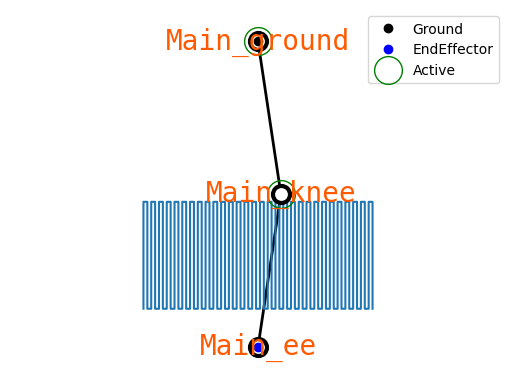

In [15]:
for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[50:, 0], trajectory[50:, 2])
gm = get_preset_by_index_with_bounds(-1)
values = gm.generate_central_from_mutation_range()
graph = gm.get_graph(values)
draw_joint_point(graph)
plt.savefig("trajectories.png")

{'Ground_connection_0_0': (-0.2001, 0.1999), 'Ground_connection_0_2': (-0.1, 0.1), 'main_knee_2': (-0.30000000000000004, -0.1), 'branch_0': (-0.3, 0.1), 'branch_2': (-0.3, -0.1)}


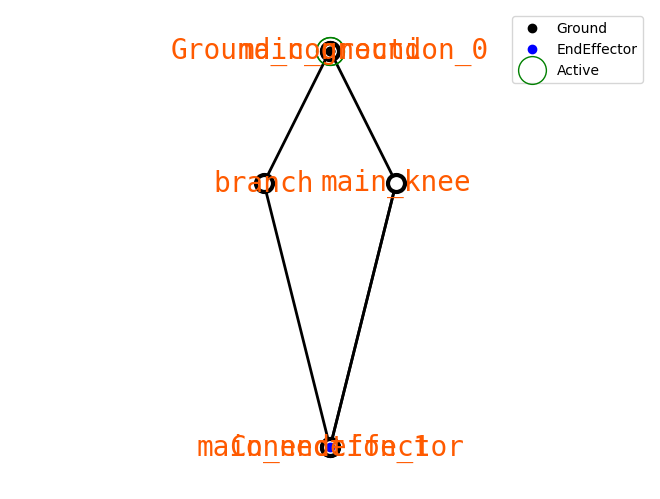

In [16]:
tp = TopologyManager2D()
# creates ground connection
tp.add_connection(ground=True, self_mutation_range= [(-0.2001, 0.1999),None,(-0.1, 0.1)], dependent_mutation_range=[(-0.3,0.1),None,(-0.3,-0.1)])

main_ground_jp = JointPoint(r=None, w=np.array([0, 1, 0]), active=True, name='main_ground',attach_ground=True, attach_endeffector=False)
tp.add_absolute_node(jp=main_ground_jp, initial_coordinates=np.array([0, 0, 0]), mutation_range=[None,None,None], freeze_pos=np.array([0,0,0]))

main_knee_jp = JointPoint(r = None, w=np.array([0, 1, 0]), active=False, name='main_knee', attach_ground=False, attach_endeffector=False)
tp.add_absolute_node(jp=main_knee_jp, parent_branch_idx=0, initial_coordinates=[0.05, 0, -0.2], mutation_range=[None,None,(-0.1,0.1)], freeze_pos=np.array([0.1,0,None]))

# creates connection on the first link
tp.add_connection(ground=False, self_mutation_range= [(-0.2,0.2),None,(-0.4,0.4)], dependent_mutation_range=[(-0.1,0.1),None,(-0.1,0.1)])

main_endeffector_jp = JointPoint(r = None, w=np.array([0, 1, 0]), active=False, name='main_endeffector',attach_ground=False, attach_endeffector=True)
tp.add_absolute_node(jp=main_endeffector_jp, parent_branch_idx=0, initial_coordinates=np.array([0.0, 0, -0.6]), mutation_range=[None,None,None], freeze_pos=np.array([0.,0,-0.6]))

# creates connection on the second link
tp.add_connection(ground=False, self_mutation_range= [(-0.2,0.2),None,(-0.5, 0.3)], self_freeze_pos=[0.0,0,-0.4999], dependent_mutation_range=[(-0.2,0.0),None,(-0.0,0.2)])

# creates branch node and one-joint branch in the topology manager. 
branch_jp = JointPoint(r=None, w=np.array([0, 1, 0]), active=False, name='branch', attach_ground=False, attach_endeffector=False)
tp.add_relative_node(branch_jp)
# adds a dependent connection of the one-joint branch to the 
tp.add_dependent_connection(0,1,connect_head=True)
# adds independent connection to the second link finishing the branch building
tp.add_independent_connection(tp.branch_ends[1][1],tp.connections[2].connection_jp)
tp.set_mutation_ranges()
print(tp.mutation_ranges)
tp.visualize()


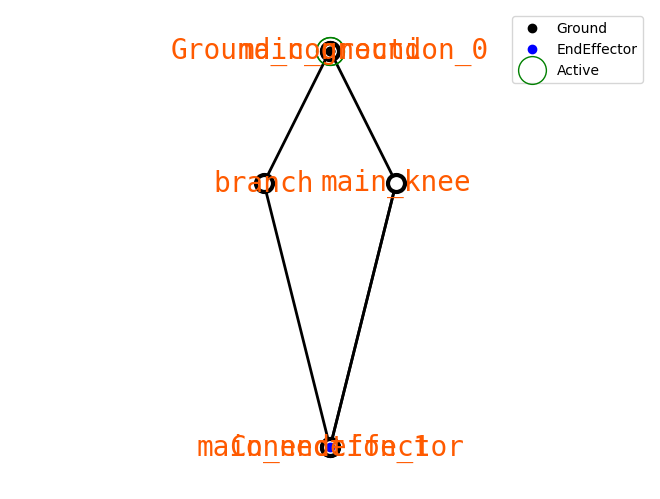

In [17]:
draw_joint_point(tp.graph, draw_labels=False)
plt.savefig("./parallel_mech.png")

In [18]:
fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(graph, builder)
constrain_error, results = soft_constrain.calculate_constrain_error(crag, fixed_robot, free_robot)
constrain_error

0.0

In [19]:
pin.seed(1)
gm = tp
# activate multiprocessing
N_PROCESS = 8
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

population_size = 64
n_generations = 30

# create the problem for the current optimization
problem = MultiCriteriaProblem(gm, builder, reward_manager,
                               soft_constrain, elementwise_runner=runner, Actuator=builder.actuator['default'])

saver = ProblemSaver(problem, f"minitaur\\jacobian_set", True)
saver.save_nonmutable()
algorithm = AGEMOEA2(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 2,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })

     1 |       64 |     64 |  0.000000E+00 |             f
     2 |      128 |     64 |  0.000000E+00 |             f
     3 |      192 |     64 |  0.000000E+00 |             f
     4 |      256 |     64 |  0.000000E+00 |             f
     5 |      320 |     64 |  0.000000E+00 |             f
     6 |      384 |     64 |  0.000000E+00 |             f
     7 |      448 |     64 |  0.000000E+00 |             f
     8 |      512 |     64 |  0.000000E+00 |             f
     9 |      576 |     64 |  0.000000E+00 |             f
    10 |      640 |     64 |  0.000000E+00 |             f
    11 |      704 |     64 |  0.000000E+00 |             f
    12 |      768 |     64 |  0.000000E+00 |             f
    13 |      832 |     64 |  0.000000E+00 |             f
    14 |      896 |     64 |  0.000000E+00 |             f
    15 |      960 |     64 |  0.000000E+00 |             f
    16 |     1024 |     64 |  0.000000E+00 |             f
    17 |     1088 |     64 |  0.000000E+00 |            